In [66]:
import math
import numpy as np
import matplotlib.pyplot as plt
import hashlib
import string
import random

# Actividad Evaluada 2: Filtros de Bloom

## Simulación de Filtros de Bloom

Escribe un programa que pueda simular la probabilidad de falsos positivos que ocurren en un Filtro de Bloom cuando le entregamos un string que no es parte de su set de llaves. Espećıficamente, tu 
programa debe recibir como parámetros:

- El tamaño n del vector de bits B del Filtro de Bloom.

- La cantidad k de hashes a usar.

- La cardinalidad m del conjunto M de valores conocidos.

- La cantidad s de simulaciones a hacer.

Tu simulación debe incializar un filtro de bloom, y luego probar con s strings aleatorios que no estén en M , revisando si esos string son marcados como falsos positivos por el algoritmo, a fin de estimar la probabilidad. Puedes usar la librer̀ıa hashlib de python para programar tus tablas de hash.

Ahora, ejecuta tu simulación una cantidad s = 1000 veces para combinaciones de parámetros m = 1000. 
n = [m, 2m, 3m, 4m, 5m, 6m, 7m, 8m] y k = [1, 2, 3, 4, 5].

¿Qué valores encontraste que disminuyan la probabilidad de falsos positivos?



In [48]:
class BloomFilters:
    def __init__(self, m, k):
        self.m = m 
        self.bit_vector = self.make_vector(m)
        self.hash_functions = self.make_functions(k)

    def hash_function(self, input_string, salt):
        combined_input = f"{input_string}-{salt}"
        hash_value = int(hashlib.sha256(combined_input.encode()).hexdigest(), 16)
        return hash_value % self.m

    def make_functions(self, k):
        functions = []
        for num in range(k):
            functions.append(lambda x, salt=num: self.hash_function(x, salt))
        return functions

    def make_vector(self, m):
        return [False] * m

    def add(self, text):
        for function in self.hash_functions:
            index = function(text)
            self.bit_vector[index] = True

    def search(self, text):
        for function in self.hash_functions: 
            index = function(text)
            if not self.bit_vector[index]:
                return False
        return True

In [49]:
def random_string_list(lenght):
    string_list = []
    for i in range(lenght):
        output_string = ''.join(random.SystemRandom().choice(string.ascii_letters + string.digits) for _ in range(random.randint(0,15)))
        string_list.append(output_string)
    return string_list

def percentage_false_positives(results):
    return int((results.count(False)/len(results))*100)

In [50]:
# Valores que se pueden cambiar 
m = 1000
s = 25

# Pruebas de Bloom que vamos a hacer
bits = [m*(x + 1) for x in range(5)]
num_func_hash = [x + 1 for x in range(5)]

In [51]:
# Por la cantidad de tests se demora aprox 30 seg en correr.
trials = {}

for trial in range(0, s):
    percentages = {}
    for bit in bits:
        for num in num_func_hash:
            results = []

            bloom_filter = BloomFilters(bit, num)

            in_filter = random_string_list(m)
            out_filter = random_string_list(m)

            for value in in_filter:
                bloom_filter.add(value)
            for non_value in out_filter:
                results.append(bloom_filter.search(non_value))
            percentages[(bit, num)] = percentage_false_positives(results)
    trials[trial] = percentages

In [52]:
mean_results = {}
cumulative_sums = {}
counts = {}

for trial, percentages in trials.items():
    for key, value in percentages.items():
        if key not in cumulative_sums:
            cumulative_sums[key] = 0
            counts[key] = 0
        
        cumulative_sums[key] += value
        counts[key] += 1

for key in cumulative_sums:
    mean_results[key] = int(cumulative_sums[key] / counts[key])


In [67]:
x_values = sorted(set(key[0] for key in mean_results.keys()))
y_values = sorted(set(key[1] for key in mean_results.keys()))
results = np.array([[mean_results.get((x, y), 0) for y in y_values] for x in x_values])

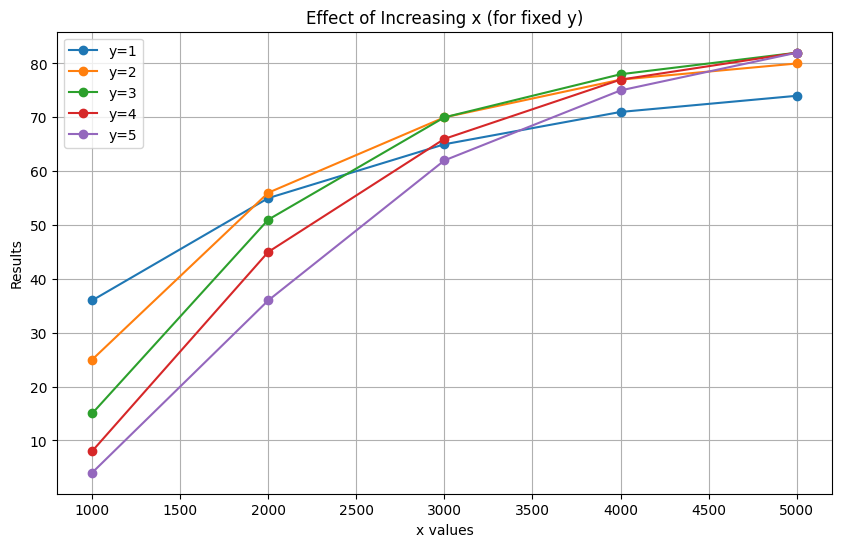

In [68]:
plt.figure(figsize=(10, 6))
for y in y_values:
    plt.plot(x_values, results[:, y-1], marker='o', label=f'y={y}')
plt.title('Effect of Increasing x (for fixed y)')
plt.xlabel('x values')
plt.ylabel('Results')
plt.legend()
plt.grid()
plt.show()

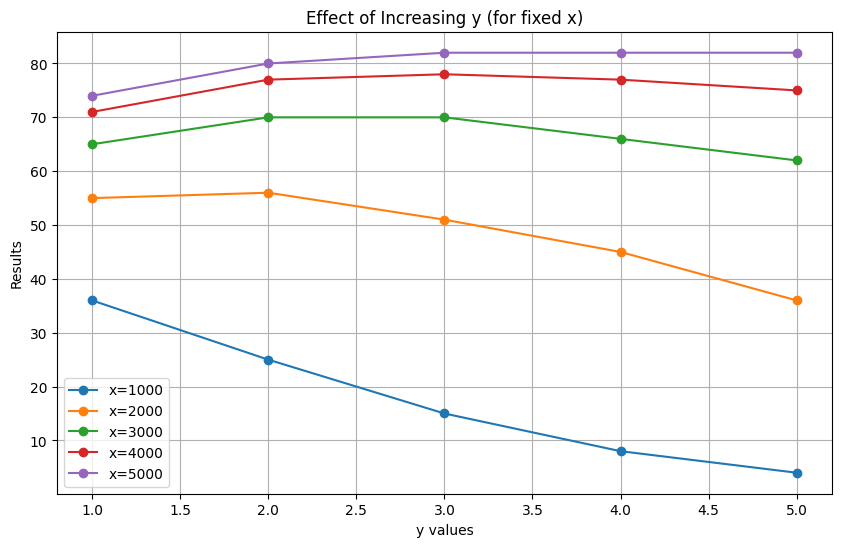

In [69]:
plt.figure(figsize=(10, 6))
for x in x_values:
    plt.plot(y_values, results[x_values.index(x)], marker='o', label=f'x={x}')
plt.title('Effect of Increasing y (for fixed x)')
plt.xlabel('y values')
plt.ylabel('Results')
plt.legend()
plt.grid()
plt.show()

## Filtros de Bloom temporales

Supon ahora que tienes un nuevo conjunto M ′ con m′ = 4m valores.
Tu deber será diseñar un esquema de filtros de Bloom que, con espacio 2n, sea capaz de lograr una probabilidad de falsos positivos similar a la de la parte 1 para ese n y m dado.
Vas a poder lograr esto debido a la siguiente suposición: En cada instante de tiempo ves aleatoriamente un 20% de los valores de M ′. Si no ves un valor de M ′ en cuatro instantes de tiempo, puedes asumir que ese valor de M ′ ya no existe. Entonces:

1. Explica como podemos usar un arreglo de n posiciones B, con dos bits asociados a cada una, para
poder simular una accion de borrado en un filtro de bloom que efectivamente elimine una posición de
B si ninguno de los elementos de M ′ cuyos hashes fueron a parar a esa posición en B se ha visto en
cuatro intervalos de tiempo.
Usa esta idea para diseñar un esquema de Filtro de Bloom que no tenga falsos negativos, y que use solo espacio 2n, pero que incluya tu estrategia a fin de liberar algo de espacio cuando no se ven elementos en cuatro intervalos de tiempo.

***Importante***: Tu esquema no podrá usar más memoria para guardar información de forma persistente salvo la permitida por el filtro de bloom: 2n. En particular, no puedes asumir que tienes M ′ posiciones adicionales de memoria sobre las que puedes ir contando que pasa con cada uno de los elementos.

2. Actualiza el código de tu simulación para que pueda simular este nuevo esquema. Ahora tu simulación recibe un parámetro adicional t, y va a funcionar de la siguiente forma: Al comienzo, debes correr tu simulación por t tiempos, simulando en cada instante que viste un 20% de los valores de M ′ y actualizando el filtro de Bloom para que tome en cuenta que los valores que
no se han visto en cuatro intervalos de tiempo seguidos ya no forman parte de M ′, de acuerdo a tu
esquema (la respuesta a la parte 2.1). Luego de eso, recibes s strings aleatorios, a fin de simular la probabilidad de un falso positivo, como antes.

3. Simula de nuevo para t = 100 y m′ = 4m, y las mismas conbinaciones de n y k que antes (recuerda
que tu espacio permitido ahora es 2n, o dos bits por cada entrada entre 0 y n− 1). Compara la mejor
probabilidad de falso positivo en este caso con tu respuesta de la parte 1.

